###### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/notebooks/cmamega_example.ipynb)

# Optimizing with CMA-ME in Jax

This notebook shows how to use QDax to find diverse and performing parameters on Rastrigin or Sphere problem with [CMA-ME](https://arxiv.org/pdf/1912.02400.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a CMA-ME emitter
- how to create a MAP-Elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [1]:
import math

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex

try:
    import jumanji
except:
    !pip install "jumanji==0.2.2"
    import jumanji

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_opt_emitter import CMAOptimizingEmitter
from qdax.core.emitters.cma_rnd_emitter import CMARndEmitter
from qdax.core.emitters.cma_improvement_emitter import CMAImprovementEmitter
from qdax.core.emitters.cma_pool_emitter import CMAPoolEmitter
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire, compute_cvt_centroids
from qdax.utils.plotting import plot_map_elites_results

from typing import Dict

2025-11-21 10:51:11.637352: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/jumpy.py:34: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(
/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/__init__.py:26: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(


## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/pdf/2106.03894.pdf).

In [2]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 20000 #70000 #10000
num_dimensions = 1000 #1000 #@param {type:"integer"}
grid_shape = (500, 500) # (500, 500) 
batch_size = 100 #36 #@param {type:"integer"}
sigma_g = 0.5 #@param {type:"number"} # Lower than CMA-MEGA as this is non-gradient based
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
min_bd = -5.12 * 0.5 * num_dimensions #@param {type:"number"}
max_bd = 5.12 * 0.5 * num_dimensions #@param {type:"number"}
emitter_type = "imp" #@param["opt", "imp", "rnd"]
pool_size = 15 #@param {type:"integer"}
optim_problem = "rastrigin" #@param["rastrigin", "sphere"]
#@markdown ---

## Defines the scoring function: rastrigin or sphere

In [3]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

if optim_problem == "sphere":
    fitness_scoring = sphere_scoring
elif optim_problem == "rastrigin":
    fitness_scoring = rastrigin_scoring
else:
    raise Exception("Invalid opt function name given")

def clip(x: jnp.ndarray):
    in_bound = (x <= maxval) * (x >= minval)
    return jnp.where(
        in_bound,
        x,
        (maxval / x)
    )

# CHANGED: Use mean() instead of sum() to match CMA-MEGA formulation
def _behavior_descriptor_1(x: jnp.ndarray):
    return jnp.mean(clip(x[:x.shape[-1]//2]))

def _behavior_descriptor_2(x: jnp.ndarray):
    return jnp.mean(clip(x[x.shape[-1]//2:]))

def _behavior_descriptors(x: jnp.ndarray):
    return jnp.array([_behavior_descriptor_1(x), _behavior_descriptor_2(x)])

In [4]:
def scoring_function(x):
    scores, descriptors = fitness_scoring(x), _behavior_descriptors(x)
    return scores, descriptors, {}

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

## Define the metrics that will be used

In [5]:
worst_objective = fitness_scoring(-jnp.ones(num_dimensions) * 5.12)
best_objective = fitness_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)

num_centroids = math.prod(grid_shape)
num_centroids = 10000 #@param {type:"integer"}

# def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

#     # get metrics
#     grid_empty = repertoire.fitnesses == -jnp.inf
#     adjusted_fitness = (
#         (repertoire.fitnesses - worst_objective) * 100 / (best_objective - worst_objective)
#     )
#     qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) # / num_centroids
#     coverage = 100 * jnp.mean(1.0 - grid_empty)
#     max_fitness = jnp.max(adjusted_fitness)
#     return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}


def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

    # get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    adjusted_fitness = (
        (repertoire.fitnesses - worst_objective) / (best_objective - worst_objective)
    )
    qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) / num_centroids
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(adjusted_fitness)
    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

## Define initial population, emitter and MAP Elites instance

The emitter is defined using the CMAME emitter class. This emitter is given to a MAP-Elites instance to create an instance of the CMA-ME algorithm.

In [6]:
random_key = jax.random.PRNGKey(0)
# in CMA-ME settings (from the paper), there is no init population
# we multipy by zero to reproduce this setting
initial_population = jax.random.uniform(random_key, shape=(batch_size, num_dimensions)) * 0.

# centroids = compute_euclidean_centroids(
#     grid_shape=grid_shape,
#     minval=min_bd,
#     maxval=max_bd,
# )

centroids, random_key = compute_cvt_centroids(
    num_descriptors=2, 
    num_init_cvt_samples=10000, 
    num_centroids=num_centroids, 
    minval=minval, 
    maxval=maxval,
    random_key=random_key,
)

emitter_kwargs = {
    "batch_size": batch_size,
    "genotype_dim": num_dimensions,
    "centroids": centroids,
    "sigma_g": sigma_g,
    "min_count": 1,
    "max_count": None,
}

if emitter_type == "opt":
    emitter = CMAOptimizingEmitter(**emitter_kwargs)
elif emitter_type == "imp":
    emitter = CMAImprovementEmitter(**emitter_kwargs)
elif emitter_type == "rnd":
    emitter = CMARndEmitter(**emitter_kwargs)
else:
    raise Exception("Invalid emitter type")

emitter = CMAPoolEmitter(
    num_states=pool_size,
    emitter=emitter
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_fn
)

## Init the repertoire and emitter state

In [7]:
repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


## Run optimization/illumination process

In [8]:
%%time

(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    map_elites.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

CPU times: user 28 s, sys: 190 ms, total: 28.2 s
Wall time: 18.8 s


In [9]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 2000000: 3.319999933242798
imp_cross after 2000000: 0.0
imp_mut after 2000000: 0.0
imp_var after 2000000: 0.0
max_fitness after 2000000: 0.9177074432373047
qd_score after 2000000: 0.02293066866695881
succ_cross after 2000000: 0
succ_mut after 2000000: 0
succ_var after 2000000: 0


## Plot results

Update the savefig variable to save your results locally.

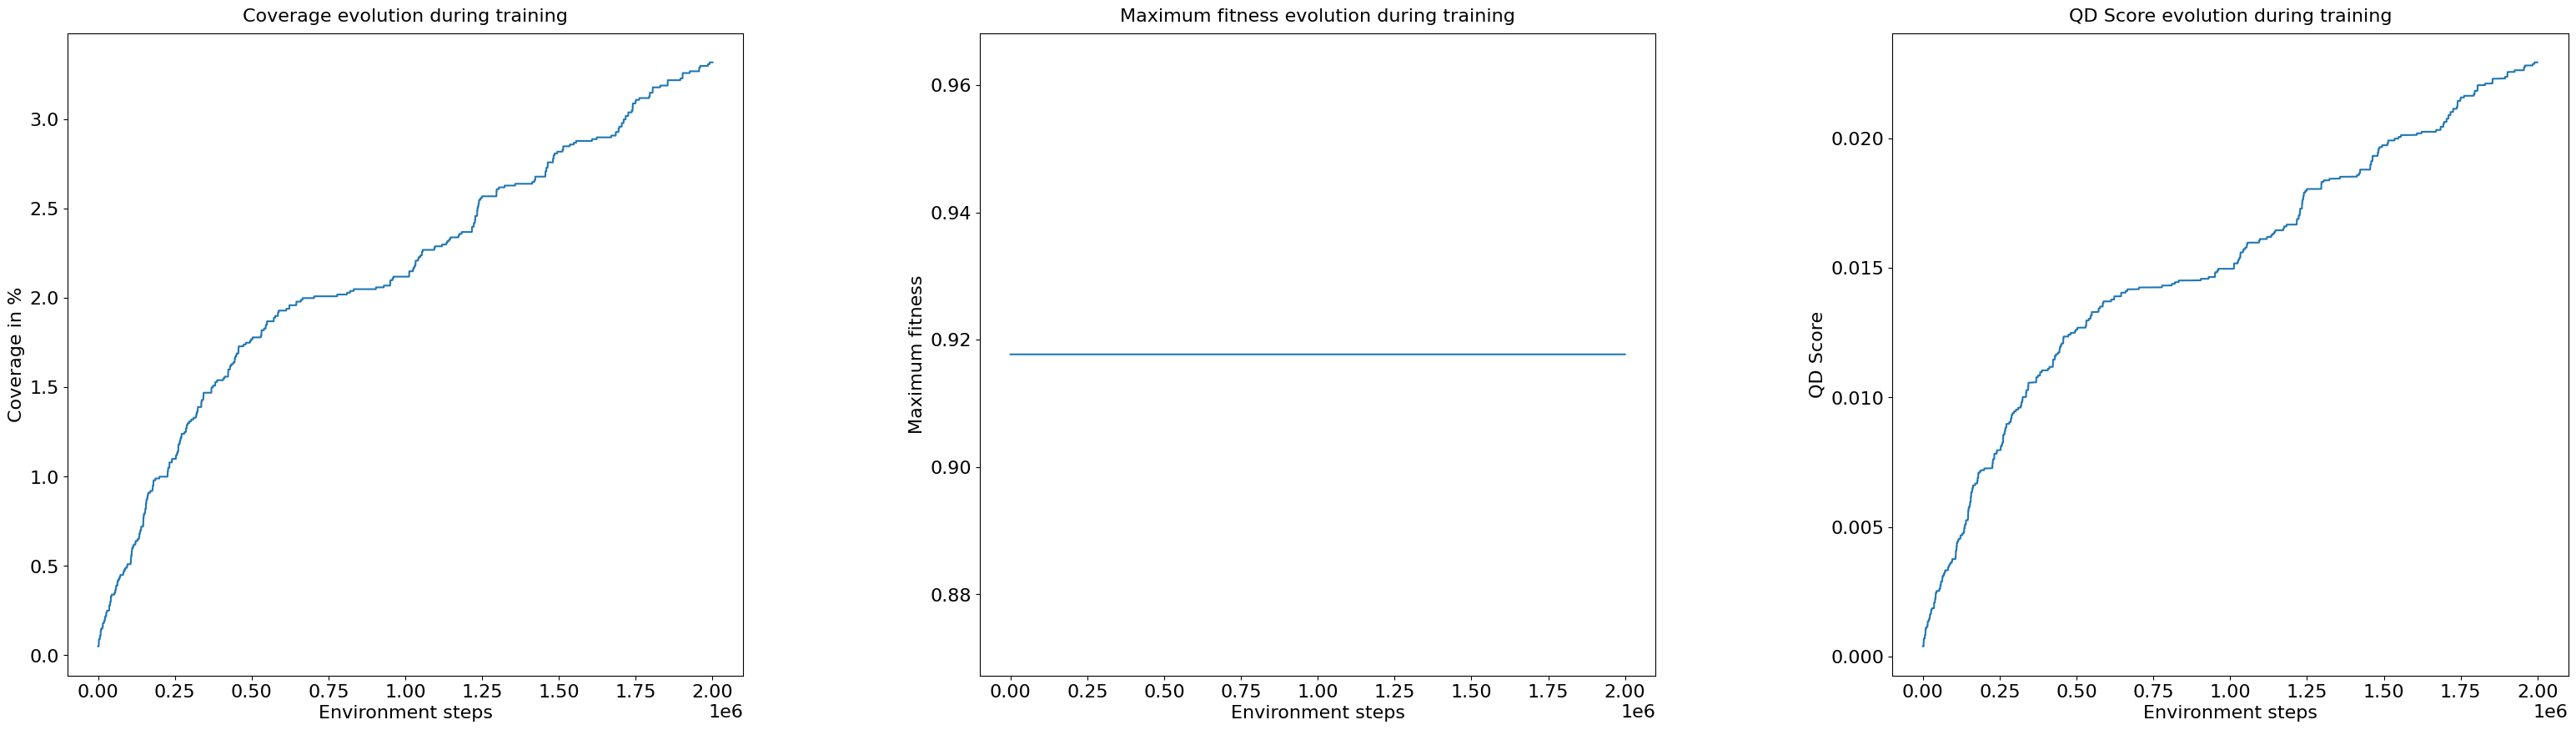

In [10]:
%matplotlib inline
env_steps = jnp.arange(num_iterations) * batch_size


# Customize matplotlib params
font_size = 16
params = {
    "axes.labelsize": font_size,
    "axes.titlesize": font_size,
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "text.usetex": False,
    "axes.titlepad": 10,
}

mpl.rcParams.update(params)

# Visualize the training evolution and final repertoire
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40, 10))

# env_steps = jnp.arange(num_iterations) * episode_length * batch_size

axes[0].plot(env_steps, metrics["coverage"])
axes[0].set_xlabel("Environment steps")
axes[0].set_ylabel("Coverage in %")
axes[0].set_title("Coverage evolution during training")
axes[0].set_aspect(0.95 / axes[0].get_data_ratio(), adjustable="box")

axes[1].plot(env_steps, metrics["max_fitness"])
axes[1].set_xlabel("Environment steps")
axes[1].set_ylabel("Maximum fitness")
axes[1].set_title("Maximum fitness evolution during training")
axes[1].set_aspect(0.95 / axes[1].get_data_ratio(), adjustable="box")

axes[2].plot(env_steps, metrics["qd_score"])
axes[2].set_xlabel("Environment steps")
axes[2].set_ylabel("QD Score")
axes[2].set_title("QD Score evolution during training")
axes[2].set_aspect(0.95 / axes[2].get_data_ratio(), adjustable="box")

# udpate this variable to save your results locally
savefig = False
if savefig:
    figname = "cma_me_" + optim_problem + "_" + str(num_dimensions) + "_" + emitter_type + ".png"
    print("Save figure in: ", figname)
    plt.savefig(figname)

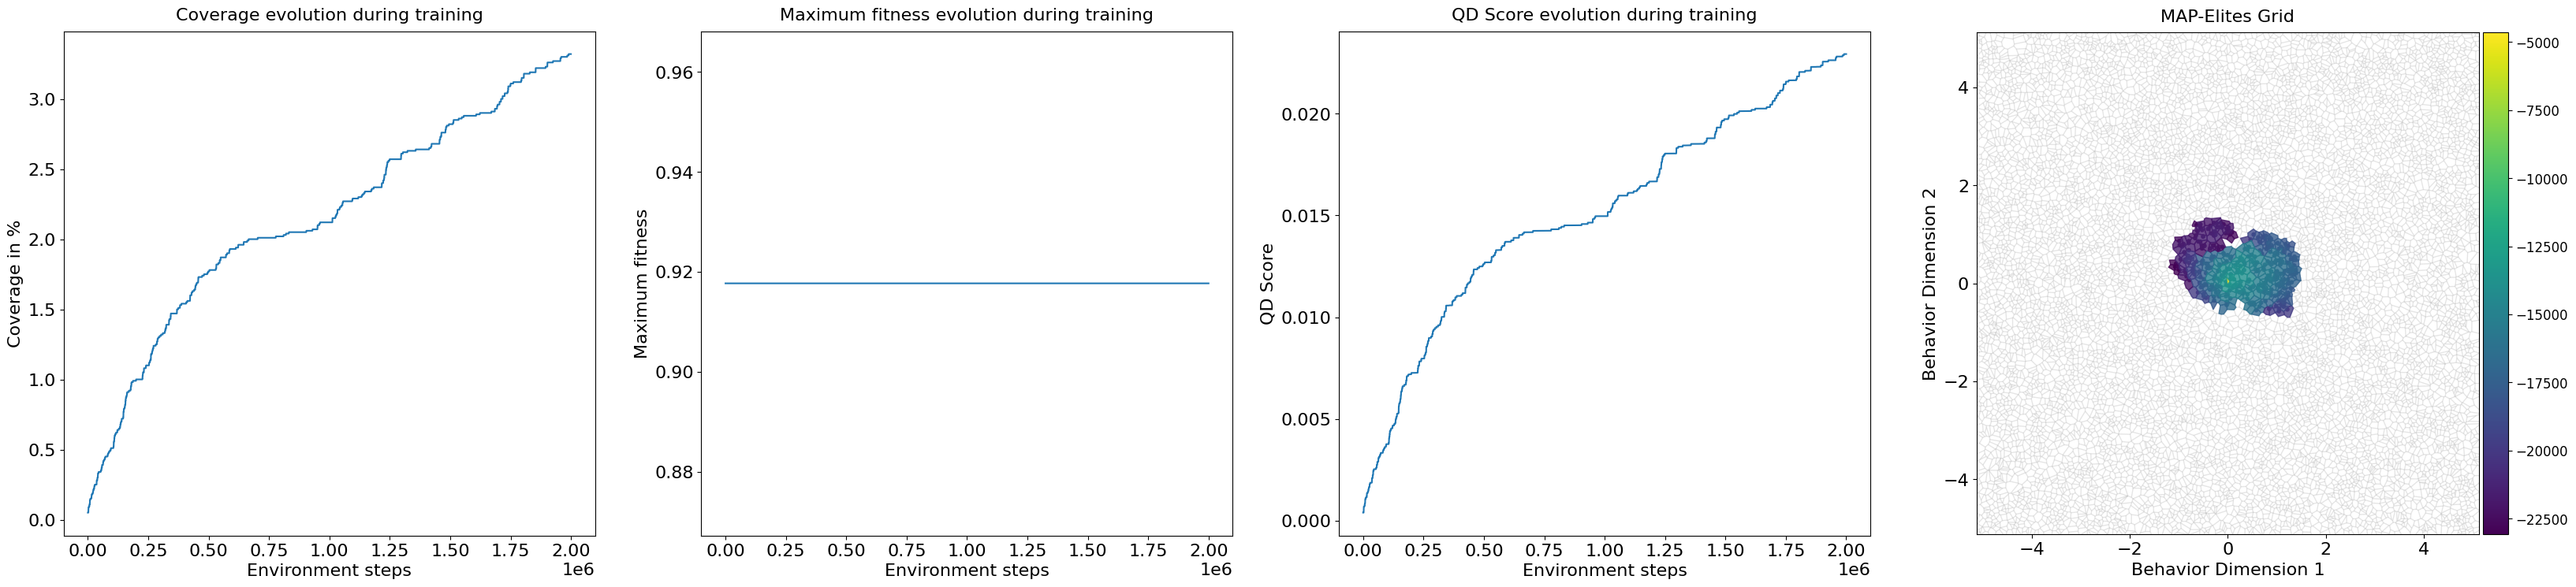

In [11]:
%matplotlib inline
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * batch_size

# create the plots and the grid
fig, axes = plot_map_elites_results(
    env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=minval, max_bd=maxval
)